In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
import yaml

sys.path.append("../")
from utils import load_model, calculate_correlation, calculate_mae

## Load experimental data

In [2]:
data_dir = "../../data/20231120_LCLS_Injector/"

In [3]:
filenames, dfs = [], []
objective_name, input_variables = None, None
for filename in os.listdir(data_dir):
    f = os.path.join(data_dir, filename)
    if filename.lower().endswith((".yml", ".yaml")):
        filenames.append(filename)
        file = data_dir + filename
        with open(file) as f:
            d = yaml.safe_load(f)
            df = pd.DataFrame(d["data"])
            vocs = d["vocs"]
        df.index = map(int, df.index)
        df = df.sort_index(axis=0).dropna(subset=["total_size"])
        dfs.append(df)
        if objective_name is None:
            objective_name = next(iter(vocs["objectives"]))
        elif not objective_name == next(iter(vocs["objectives"])):
            print(f"Objective name for file {file} doesn't match!")
        if input_variables is None:
            input_variables = list(vocs["variables"].keys())
        elif not sorted(input_variables) == list(vocs["variables"].keys()):
            print(f"Input variables for file {filename} do not match!")

In [4]:
data = pd.concat(dfs).drop_duplicates()
data

,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,SOLN:IN20:121:BCTRL,Sx,...,bad_measurement_posterior_mean,bad_measurement_posterior_sd,bad_measurement_prior_mean,sigma_xy,total_size,total_size_posterior_mean,total_size_posterior_sd,total_size_prior_mean,xopt_error,xopt_runtime
0,-0.010833,-0.005485,-3.603751,3.607328,-2.989077,2.836140,5.658844,-2.266390,0.480275,617.756258,...,NaN,NaN,NaN,702.098495,0.986209,NaN,NaN,NaN,False,63.743744
1,-0.009617,0.001231,-2.365317,2.872572,-1.097316,2.972318,5.004046,-4.096945,0.479445,166.423753,...,NaN,NaN,NaN,669.825731,1.152224,NaN,NaN,NaN,False,57.558903
2,0.013222,-0.015901,-3.283868,3.271384,-1.865775,1.373363,3.453667,-5.392014,0.479941,620.788417,...,NaN,NaN,NaN,625.646318,1.168620,NaN,NaN,NaN,False,49.833025
3,0.018079,-0.010257,-2.693100,1.568423,-2.857405,1.333971,3.155543,-3.419503,0.480613,538.979509,...,0.0,0.014139,0.0,553.357217,0.967016,0.518971,0.318581,0.521057,False,48.699289
4,0.004089,-0.002145,-3.148272,2.681761,-3.219087,1.973335,4.021282,-2.303685,0.479456,118.709344,...,0.0,0.009978,0.0,204.754363,0.252876,0.523026,0.335905,0.533658,False,25.665889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,0.002212,-0.005326,-3.372023,2.687915,-2.005203,-0.129548,4.444914,-2.638148,0.480056,110.207341,...,0.0,0.003471,0.0,154.806658,0.156297,0.120321,0.108411,0.516850,False,35.476792
19,0.008523,-0.004270,-3.755453,2.754605,-2.054479,-0.259974,4.076596,-3.762284,0.480046,42.412721,...,0.0,0.003588,0.0,111.004586,0.171174,0.302081,0.179344,0.466596,False,50.465630
20,0.005546,-0.003190,-2.819518,2.403743,-2.331062,0.857063,4.775846,-3.309395,0.480138,134.409734,...,0.0,0.003373,0.0,213.965602,0.246035,0.283714,0.152429,0.500605,False,27.284719
21,0.002556,-0.002652,-3.241660,2.715782,-1.438134,-1.078220,4.614978,-4.027408,0.480335,84.404220,...,0.0,0.003550,0.0,131.695050,0.148382,0.243634,0.146689,0.450455,False,40.848626


## Load NN prior models

In [5]:
regs = [None, "low", "mid", "high"]
model_labels = ["uncalibrated", "low-reg", "mid-reg", "high-reg"]
models = []
for reg in regs:
    model = load_model(
        input_variables=input_variables,
        model_path="../lcls_cu_injector_nn_model/",
        calibration_path="../calibration/",
        reg=reg,
    )
    models.append(model)

In [6]:
targets = torch.from_numpy(data[objective_name].values)
input_tensor = torch.from_numpy(data[input_variables].values)
predictions = [model(input_tensor) for model in models]

## Model correlations

In [7]:
correlations = [calculate_correlation(p, targets).item() for p in predictions]

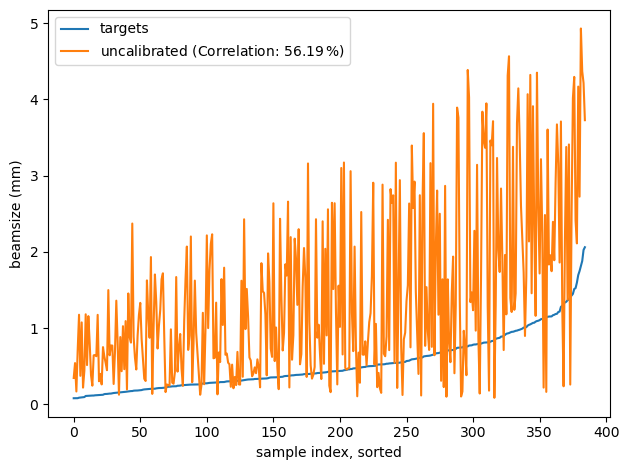

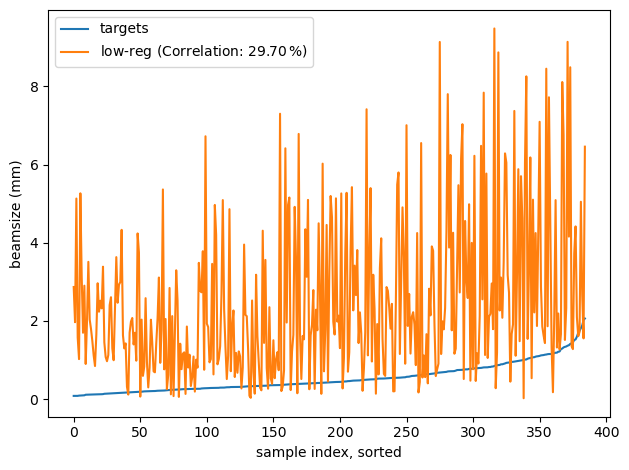

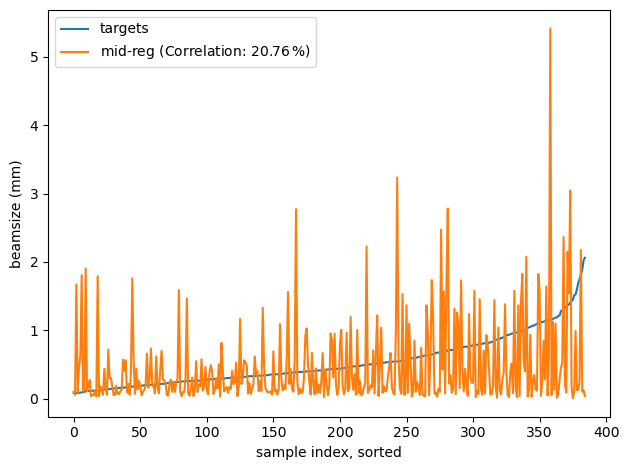

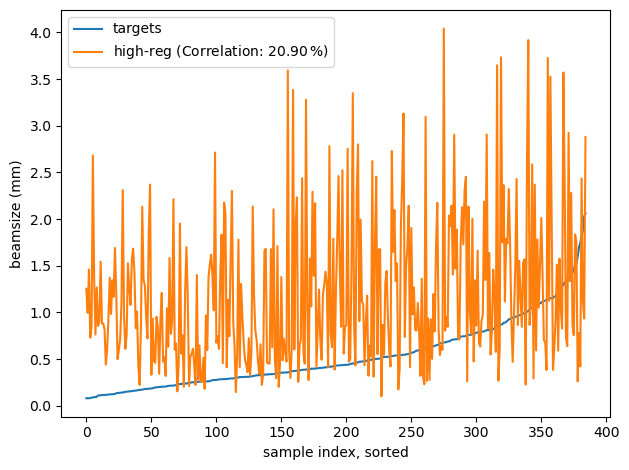

In [8]:
idx_sort = torch.argsort(targets)

for i in range(len(models)):
    fig, ax = plt.subplots(1, 1)
    ax.plot(targets[idx_sort], label="targets")
    label = r"{} (Correlation: {:.2f}$\,$%)".format(model_labels[i], 1e2 * correlations[i])
    ax.plot(predictions[i][idx_sort], label=label)
    ax.set_xlabel("sample index, sorted")
    ax.set_ylabel("beamsize (mm)")
    ax.legend()
    fig.tight_layout()

## Model errors

In [9]:
maes = [calculate_mae(p, targets).item() for p in predictions]

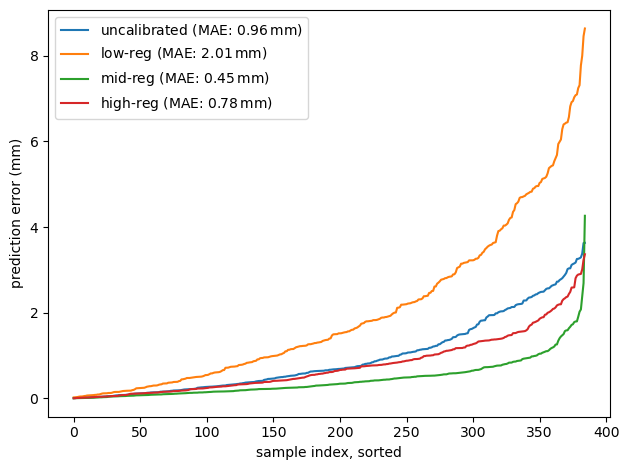

In [10]:
fig, ax = plt.subplots(1, 1)
for i in range(len(models)):
    errors = torch.abs(predictions[i] - targets)
    idx_sort = torch.argsort(errors)
    label = r"{} (MAE: {:.2f}$\,$mm)".format(model_labels[i], maes[i])
    ax.plot(errors[idx_sort], label=label)
ax.set_xlabel("sample index, sorted")
ax.set_ylabel("prediction error (mm)")
ax.legend()
fig.tight_layout()

## Model metrics

In [11]:
metrics = pd.DataFrame({"Correlation": correlations, "MAE": maes})
metrics.index = model_labels
metrics

,Correlation,MAE
uncalibrated,0.561863,0.959852
low-reg,0.297029,2.014342
mid-reg,0.207575,0.450947
high-reg,0.209029,0.778604


In [12]:
run_metrics = pd.DataFrame(
    columns=pd.MultiIndex.from_product([["Correlation", "MAE"], model_labels])
)
for filename, df in zip(filenames, dfs):
    run_targets = torch.from_numpy(df[objective_name].values)
    run_input_tensor = torch.from_numpy(df[input_variables].values)   
    run_predictions = [model(run_input_tensor) for model in models]
    run_correlations = [calculate_correlation(p, run_targets).item() for p in run_predictions]
    run_maes = [calculate_mae(p, run_targets).item() for p in run_predictions]
    run_metrics.loc[len(run_metrics.index)] = run_correlations + run_maes
run_metrics.index = [os.path.splitext(filename)[0] for filename in filenames]
run_metrics.style.set_table_styles([
    {"selector": "th.col_heading.level0", "props": "text-align: center; font-size: 1.5em;"},
])

In [13]:
run_metrics_summary = pd.DataFrame(columns=["Correlation per Run", "MAE per Run"])
for label in model_labels:
    row = []
    for name in ["Correlation", "MAE"]:
        mean, std = run_metrics[name][label].mean(), run_metrics[name][label].std()
        row.append("{:.2f} +- {:.2f}".format(mean, std))
    run_metrics_summary.loc[len(run_metrics_summary.index)] = row
run_metrics_summary.index = model_labels
run_metrics_summary

,Correlation per Run,MAE per Run
uncalibrated,0.56 +- 0.37,1.00 +- 0.31
low-reg,0.29 +- 0.18,2.13 +- 0.90
mid-reg,0.35 +- 0.21,0.54 +- 0.24
high-reg,0.20 +- 0.19,0.78 +- 0.27
